In [1]:
import GSOM
import numpy as np
import matplotlib.pyplot as plt


Growth Threshold = 0.10258658877510116
Average error 0.04724263322560785
Max error 0.09968951894524507
83


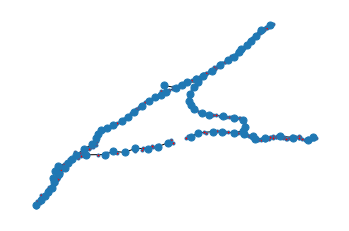

In [2]:
# x = np.linspace(0,1,60)
# y = np.sin(x)
# y_p = np.cos(x)
# print(y.shape)
# x_total = x
# y_total = y
# dataset = list(zip(x,y))
# dataset = dataset + list(zip(x,y_p))
# for h in range(4):
#     noise = np.random.normal(0, .015, y.shape)
#     x_hat = x + noise
#     np.append(x_total,x_hat)
#     noise = np.random.normal(0, .015, y.shape)
#     y_hat = y + noise
#     np.append(y_total,y_hat)
#     xy = list(zip(x_hat,y_hat))
#     plt.plot(x_hat, y_hat, '.')
#     dataset = dataset + xy



# for h in range(4):
#     noise = np.random.normal(0, .015, y_p.shape)
#     x_hat = x + noise
#     np.append(x_total,x_hat)
#     noise = np.random.normal(0, .015, y_p.shape)
#     y_hat = y_p + noise
#     np.append(y_total,y_hat)
#     xy = list(zip(x_hat,y_hat))
#     plt.plot(x_hat, y_hat, '.')
#     dataset = dataset + xy
dataset = np.load("small_scale.npy")
dataset = dataset * 1000
# dataset = list(zip(xvals,yinterp))
# dataset = list(zip(x,y))
np.random.shuffle(dataset)
# basis = GSOM.GSOM(dataset,0.95,0.15)
basis = GSOM.GSOM(dataset,0.95,0.15)

basis.train()



data = np.array(basis.data)

x_data = data[:,[0]] / 1000
y_data = data[:,[1]] / 1000

plt.plot(x_data, y_data, '.', markerfacecolor='red')
plt.ion()
basis.visualizeGraph()

plt.show()


In [13]:
import networkx as nx 

print(sum(nx.triangles(basis.network).values()) /3)

4.0
